In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [7]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [8]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [9]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:14:22 - cmdstanpy - INFO - Chain [1] start processing
02:14:23 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [11]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2648,2024-01-07,12.307175,9.982458,14.850293
2649,2024-01-08,11.552334,9.076057,13.819473
2650,2024-01-09,11.562810,9.069675,14.013552
2651,2024-01-10,11.617560,9.077547,13.961299
2652,2024-01-11,11.607655,9.228531,14.102888


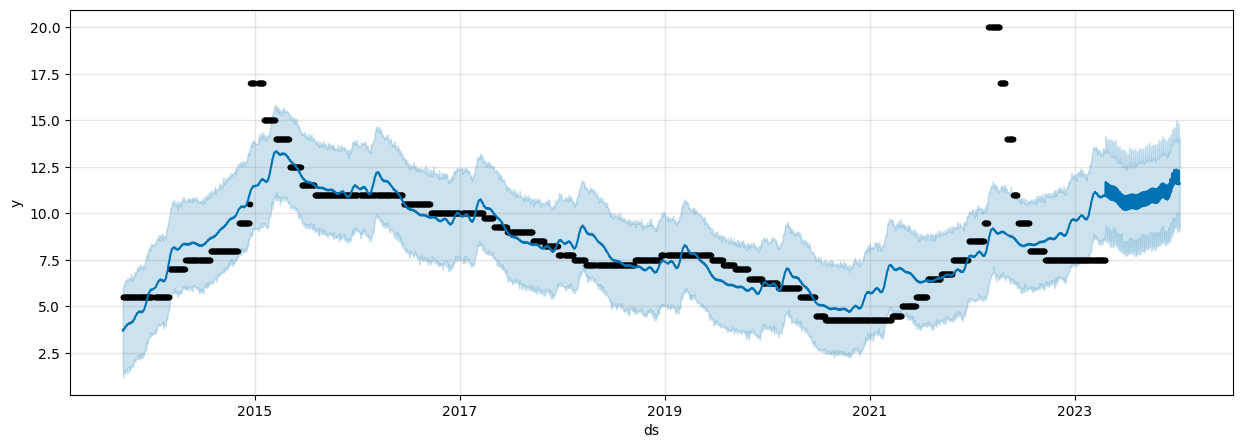

In [12]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

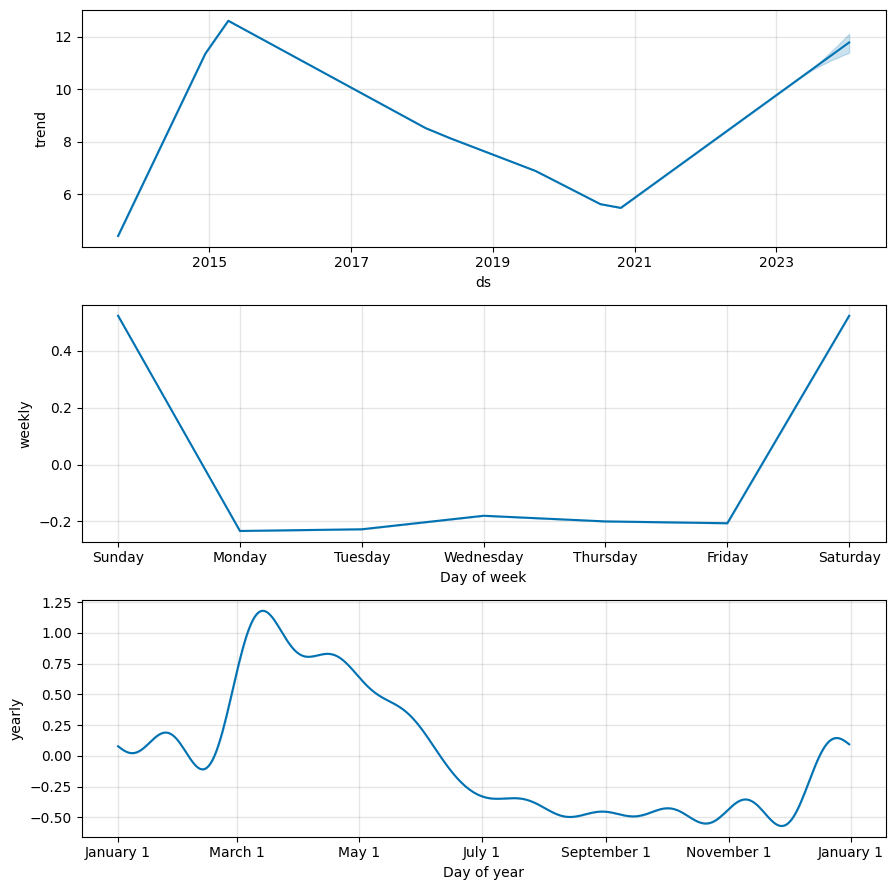

In [13]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [14]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-02,12.794484,10.169454,15.226248
261,2024-05-03,12.775614,10.349480,15.167013
262,2024-05-06,12.715655,10.149263,15.220064
263,2024-05-07,12.712527,10.271151,15.206505
264,2024-05-08,12.751936,10.256501,15.486581


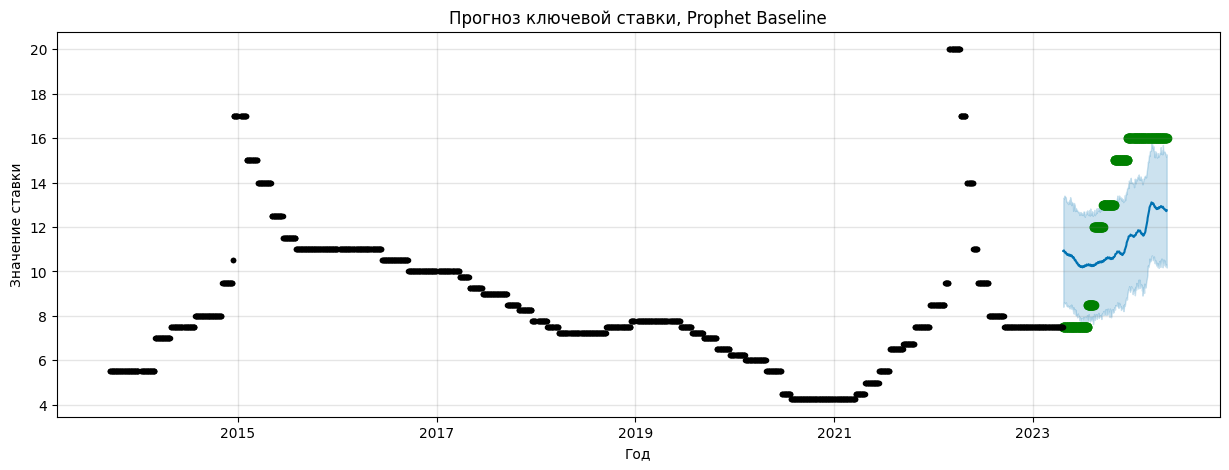

In [15]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

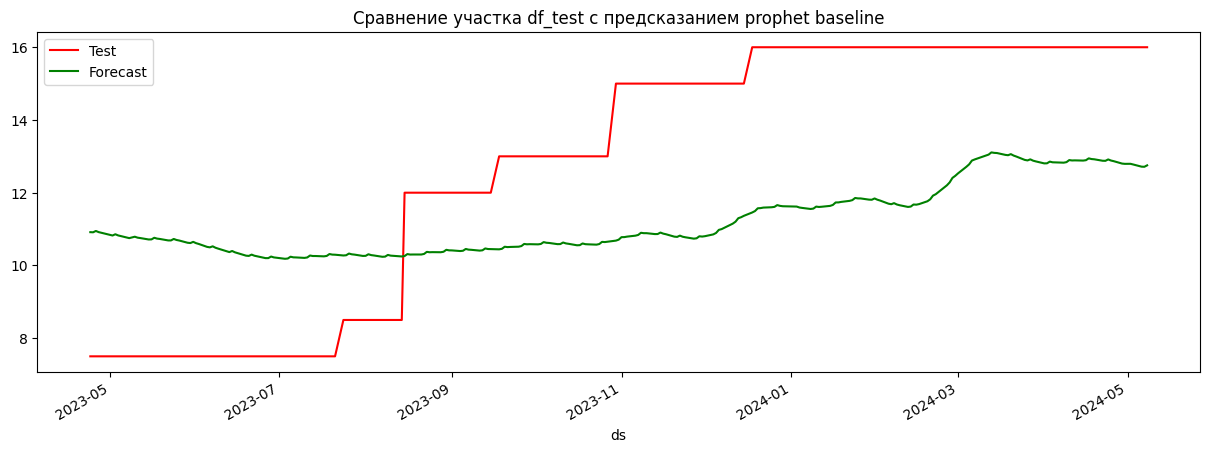

In [16]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [17]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.145376,0.261548,10.671704,3.266757


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [18]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [19]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:14:28 - cmdstanpy - INFO - Chain [1] start processing
02:14:29 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2648,2024-01-07,11.763959,9.351150,14.145576
2649,2024-01-08,11.045998,8.670186,13.599395
2650,2024-01-09,11.681948,9.296029,14.181108
2651,2024-01-10,11.735247,9.329625,14.217963
2652,2024-01-11,11.714554,9.251092,14.180850


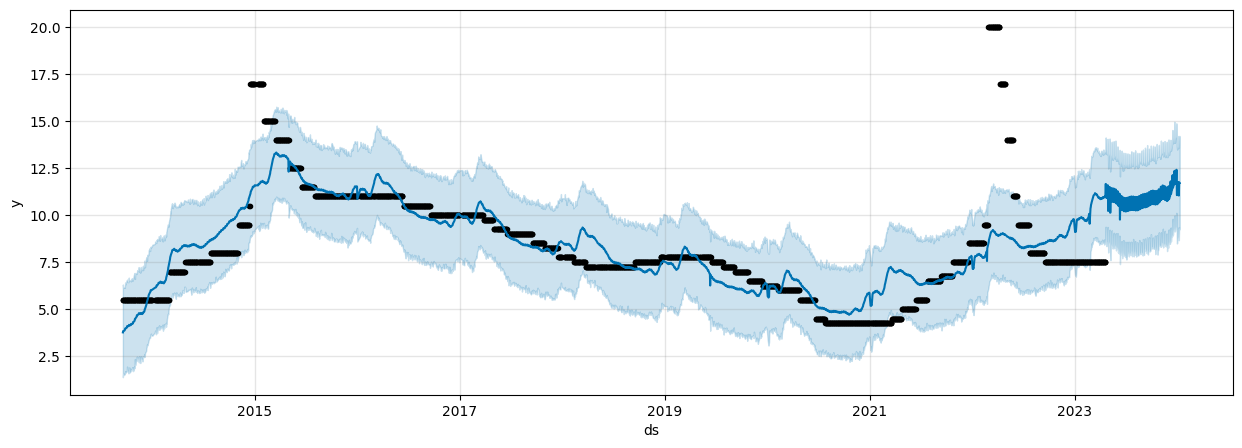

In [21]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

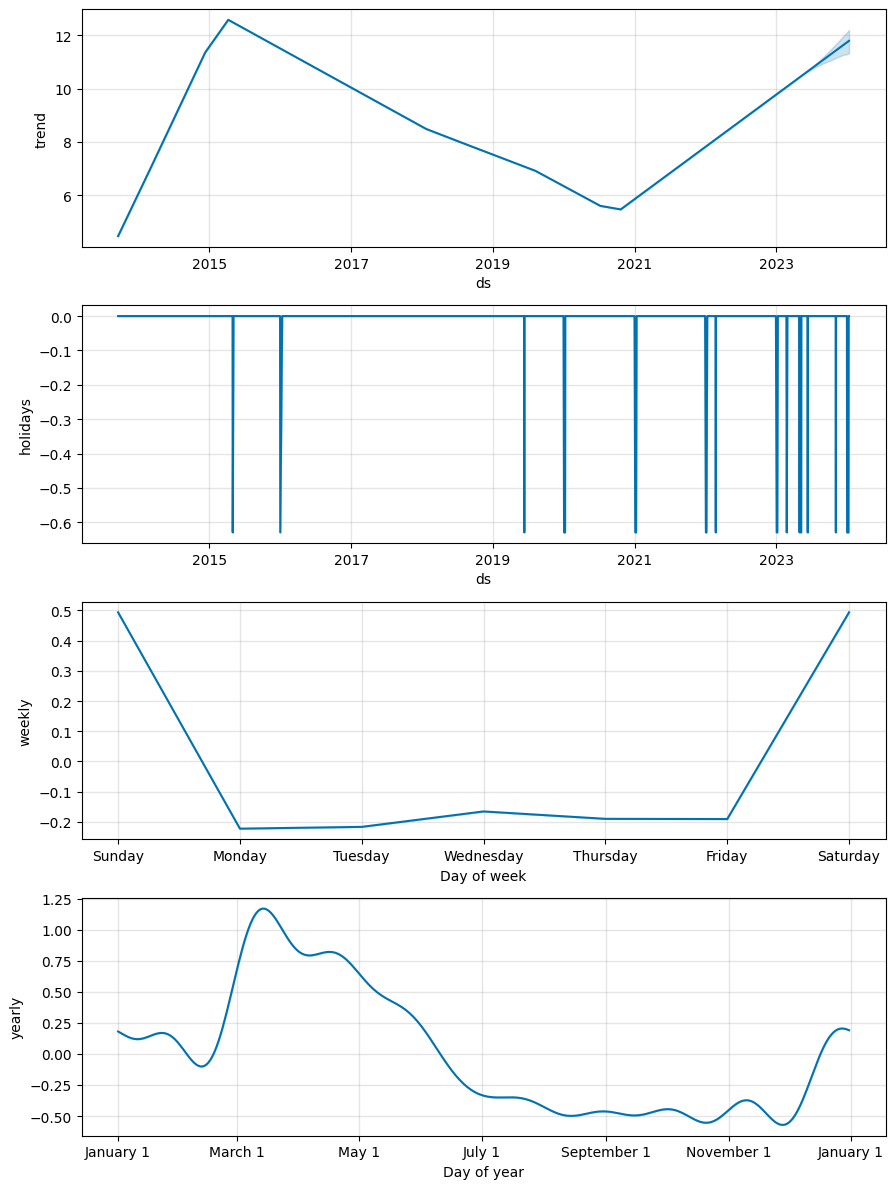

In [22]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [23]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-02,12.818849,10.315919,15.254283
261,2024-05-03,12.804716,10.345080,15.390800
262,2024-05-06,12.736028,10.071759,15.318897
263,2024-05-07,12.731328,10.401777,15.236776
264,2024-05-08,12.772824,10.508290,15.436029


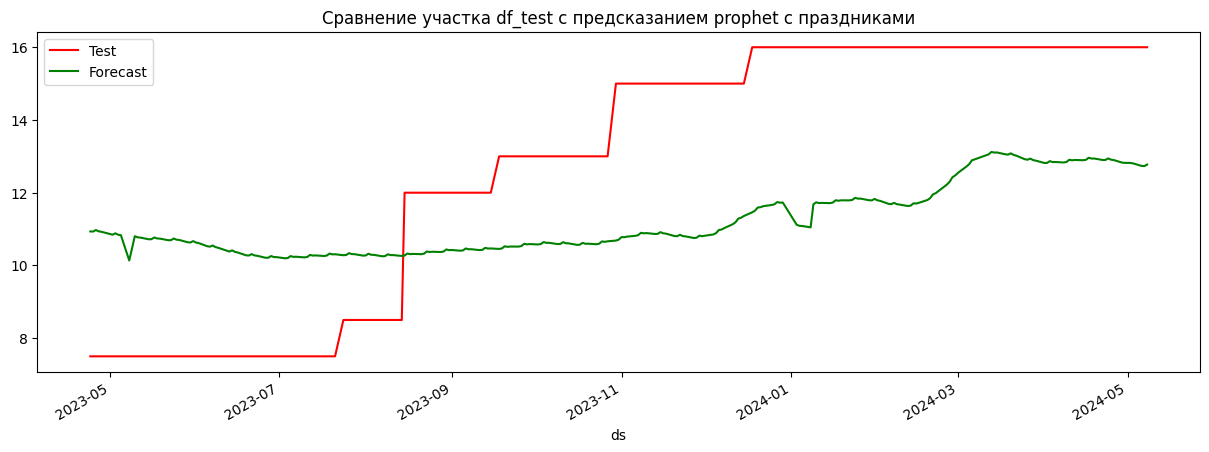

In [24]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [25]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.145376,0.261548,10.671704,3.266757
0,Prophet_with_holidays,3.143746,0.261526,10.672458,3.266873


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [26]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [27]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]

02:14:33 - cmdstanpy - INFO - Chain [1] start processing
02:14:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:01<12:56,  1.16s/it]02:14:34 - cmdstanpy - INFO - Chain [1] start processing
02:14:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:02<11:39,  1.04s/it]02:14:35 - cmdstanpy - INFO - Chain [1] start processing
02:14:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:02<10:35,  1.05it/s]02:14:36 - cmdstanpy - INFO - Chain [1] start processing
02:14:36 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:03<10:14,  1.09it/s]02:14:37 - cmdstanpy - INFO - Chain [1] start processing
02:14:37 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:04<09:46,  1.14it/s]02:14:38 - cmdstanpy - INFO - Chain [1] start processing
02:14:38 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:05<09:49,  1.13it/s]02:14:39 - cmdstanpy - INFO - Chain [1] 

In [28]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [29]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.736273,0.389544,46.610110,6.827160,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,6.252159,0.431446,53.522669,7.315919,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,6.077282,0.415744,51.532827,7.178637,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,6.034663,0.412584,50.878498,7.132917,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.705843,0.388802,45.849879,6.771254,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.897754,1.019548,296.876361,17.230100,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.477206,0.333015,24.480603,4.947788,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.607392,0.341188,26.105172,5.109322,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.609387,0.340514,26.233349,5.121850,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [30]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.659548,0.300215,14.854756,3.854187,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.659548,0.300215,14.854756,3.854187,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.659548,0.300215,14.854756,3.854187,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.659548,0.300215,14.854756,3.854187,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.673903,0.300696,14.984105,3.870931,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [31]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [32]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:32:43 - cmdstanpy - INFO - Chain [1] start processing
02:32:43 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2648,2024-01-07,12.307175,10.040848,14.557541
2649,2024-01-08,11.552334,8.934715,13.992625
2650,2024-01-09,11.562810,9.269380,13.932861
2651,2024-01-10,11.617560,9.304768,14.049259
2652,2024-01-11,11.607655,9.272584,14.021397


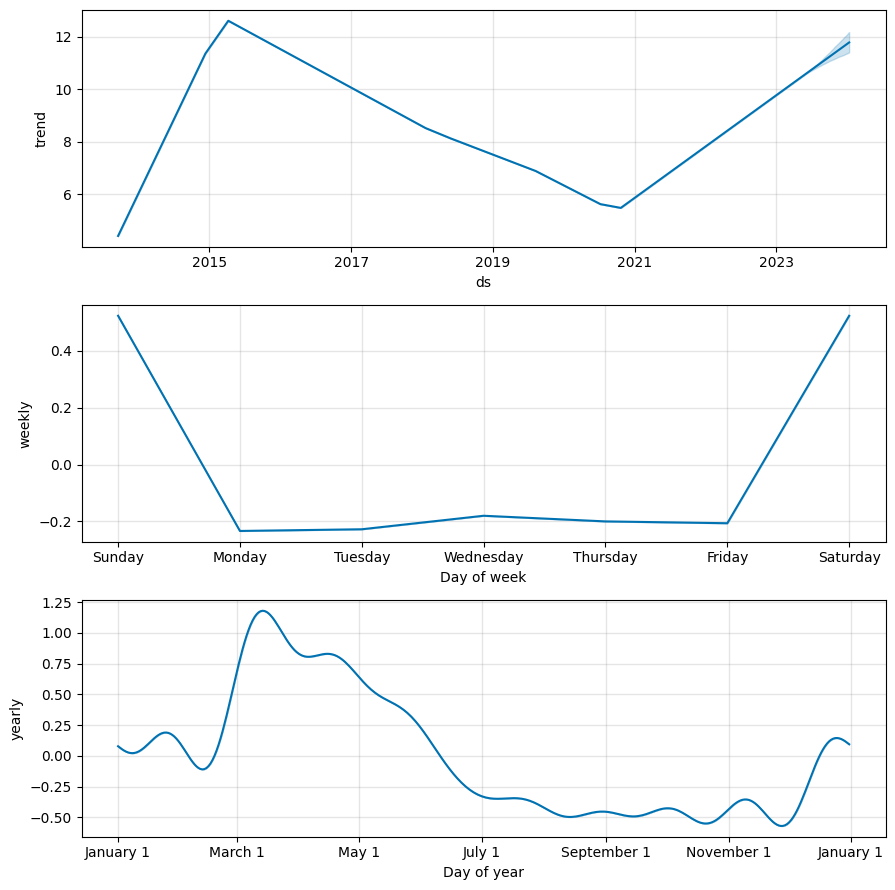

In [34]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

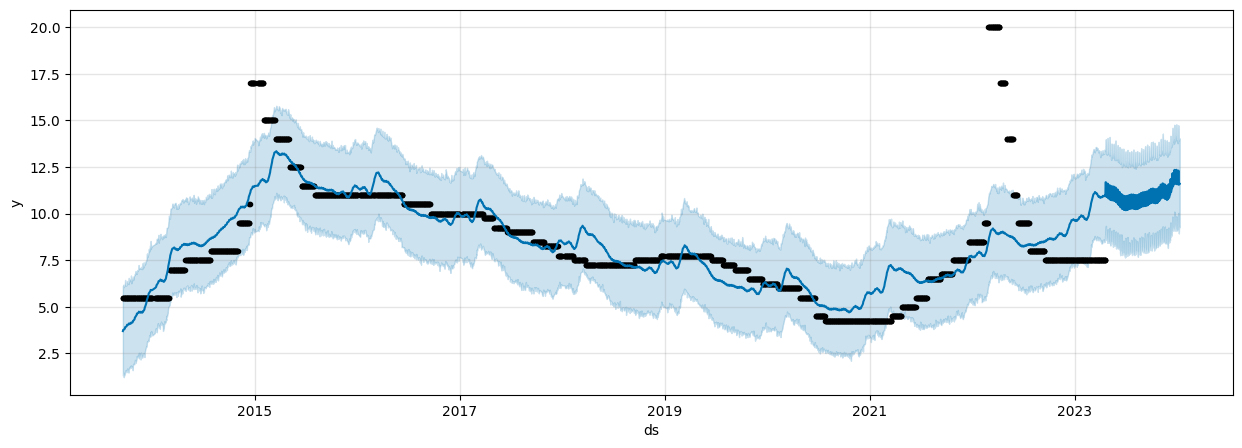

In [35]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [36]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-02,12.794484,10.353647,15.380297
261,2024-05-03,12.775614,10.147230,15.384644
262,2024-05-06,12.715655,10.230734,15.404183
263,2024-05-07,12.712527,10.148197,15.131606
264,2024-05-08,12.751936,10.317985,15.206996


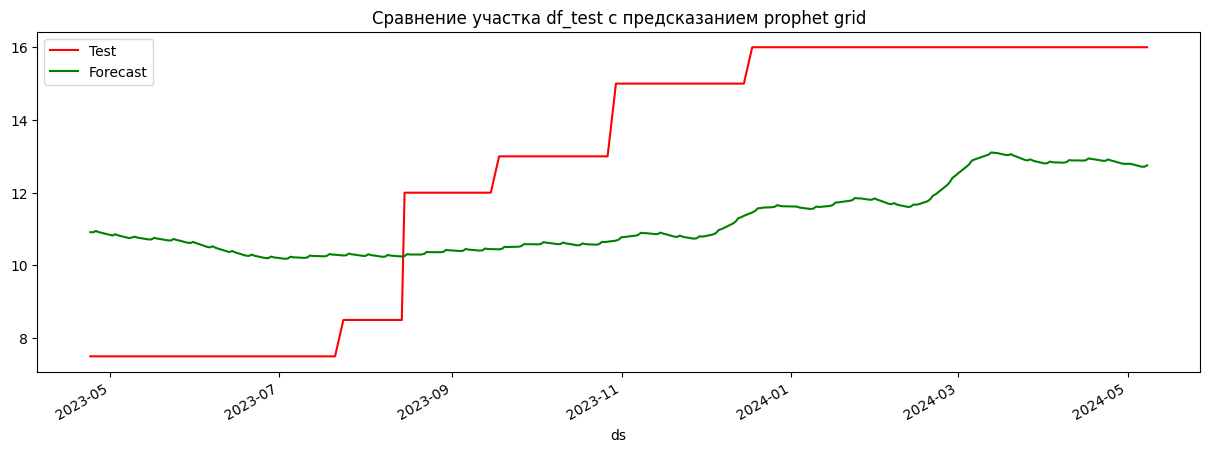

In [37]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [38]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.145376,0.261548,10.671704,3.266757
0,Prophet_with_holidays,3.143746,0.261526,10.672458,3.266873
0,Prophet_with_grid,3.145376,0.261548,10.671704,3.266757


In [39]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [82]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.194% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [83]:
# Создание df с прогнозом
future_np = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = len(df_train))
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.194% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
260,2024-05-02,16.0,11.923942,10.047868,0.450766,1.425308
261,2024-05-03,16.0,11.949371,10.053131,0.462431,1.433809
262,2024-05-06,16.0,11.971651,10.068913,0.493775,1.408964
263,2024-05-07,16.0,11.980795,10.074175,0.502791,1.403830
264,2024-05-08,16.0,12.034506,10.079433,0.510976,1.444097


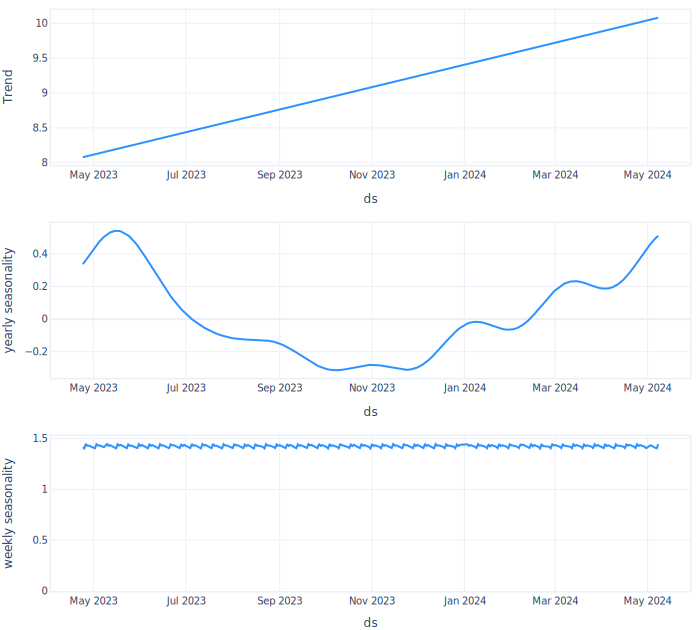

In [84]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

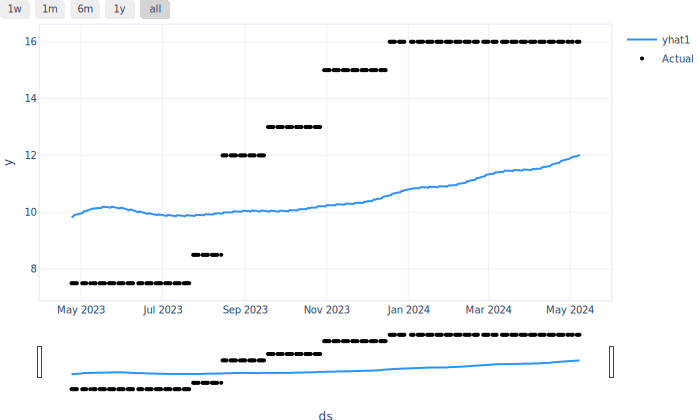

In [85]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

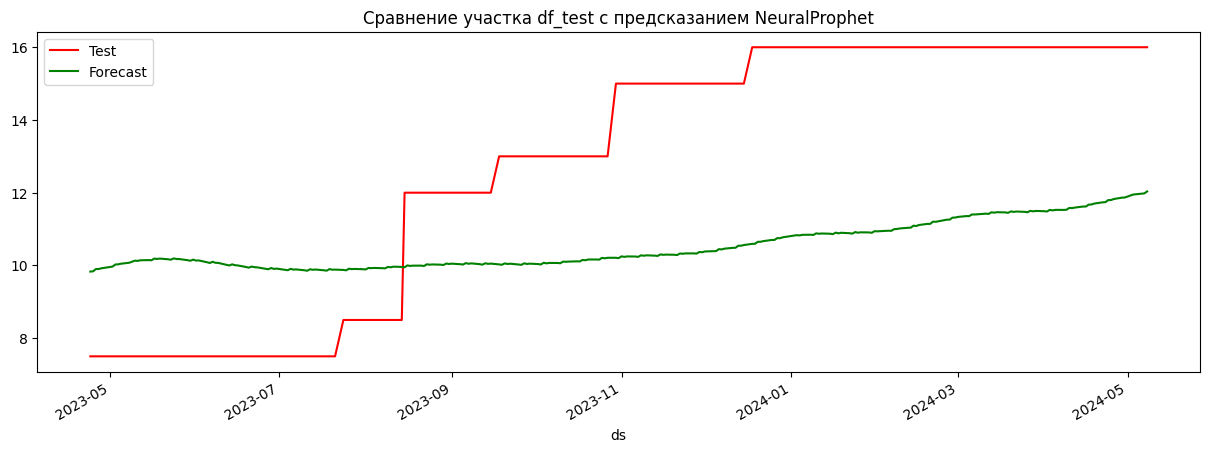

In [86]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [87]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.145376,0.261548,10.671704,3.266757
0,Prophet_with_holidays,3.143746,0.261526,10.672458,3.266873
0,Prophet_with_grid,3.145376,0.261548,10.671704,3.266757
0,NeuralProphet,3.578362,0.281630,14.375550,3.791510
0,NeuralProphet,3.552940,0.279333,14.179746,3.765600


# Обучение и прогнозирование курса на df

# Prophet baseline on df

In [88]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

03:12:14 - cmdstanpy - INFO - Chain [1] start processing
03:12:15 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# Количество предсказанных дней
pred_days_forecast = 365

In [90]:
# Создание df с прогнозом
future = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast = prophet_bl.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3013,2025-05-04,16.682633,14.088387,19.461882
3014,2025-05-05,15.881455,13.376352,18.493332
3015,2025-05-06,15.860964,13.318375,18.455378
3016,2025-05-07,15.868945,13.307373,18.518376
3017,2025-05-08,15.827036,13.257751,18.259793


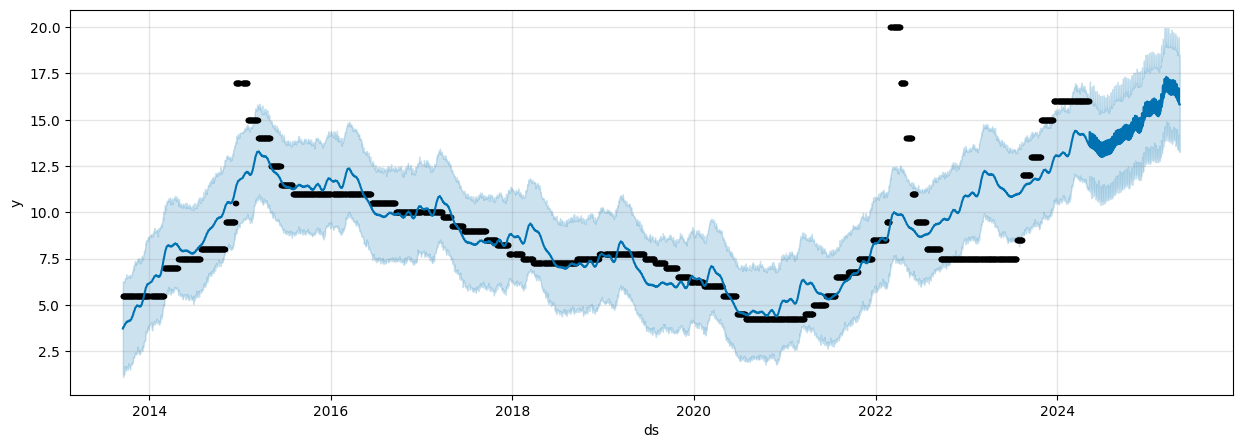

In [91]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast,ax=ax)
plt.show()

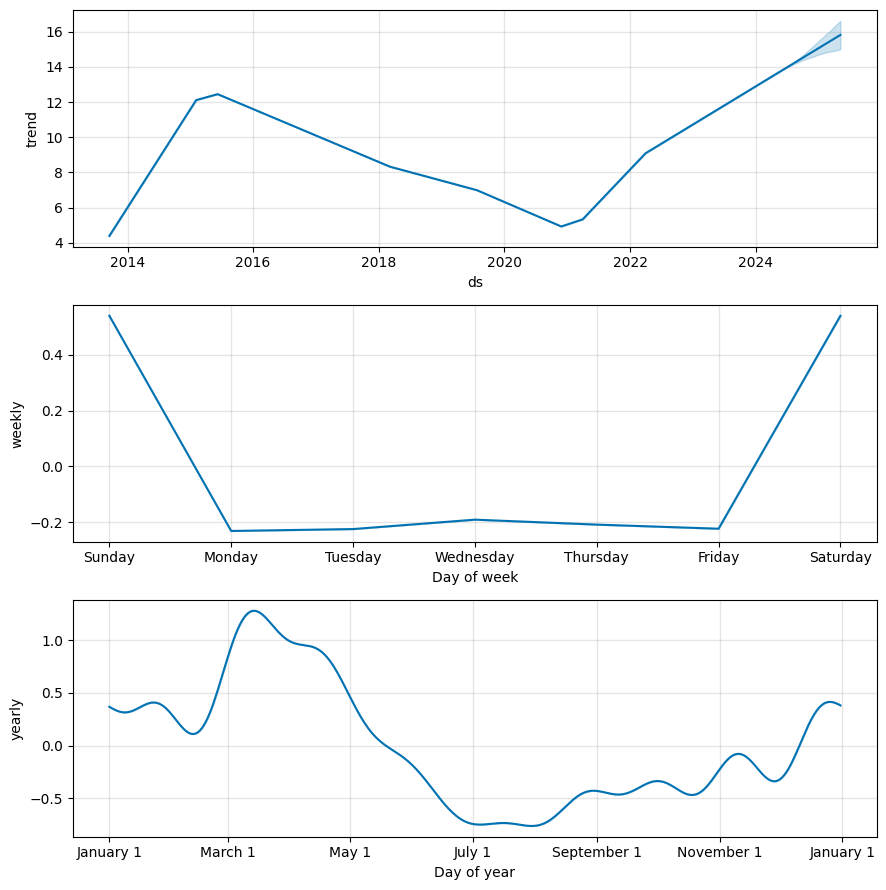

In [92]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast)
plt.show()

# Prophet best params on df

In [93]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

03:12:17 - cmdstanpy - INFO - Chain [1] start processing
03:12:18 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3013,2025-05-04,16.682633,14.047013,19.400148
3014,2025-05-05,15.881455,13.190286,18.464900
3015,2025-05-06,15.860964,13.167562,18.405518
3016,2025-05-07,15.868945,13.126699,18.480942
3017,2025-05-08,15.827036,13.104771,18.476257


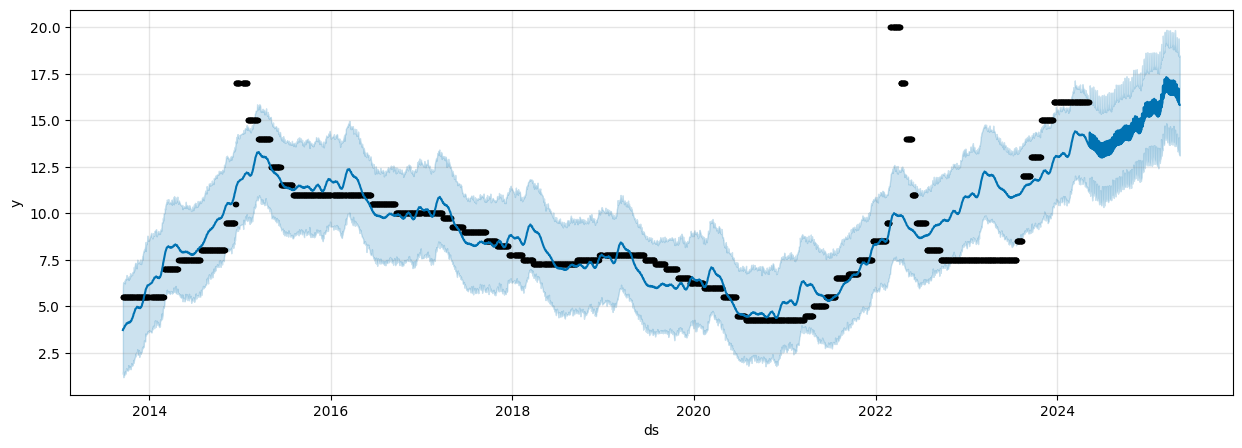

In [95]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

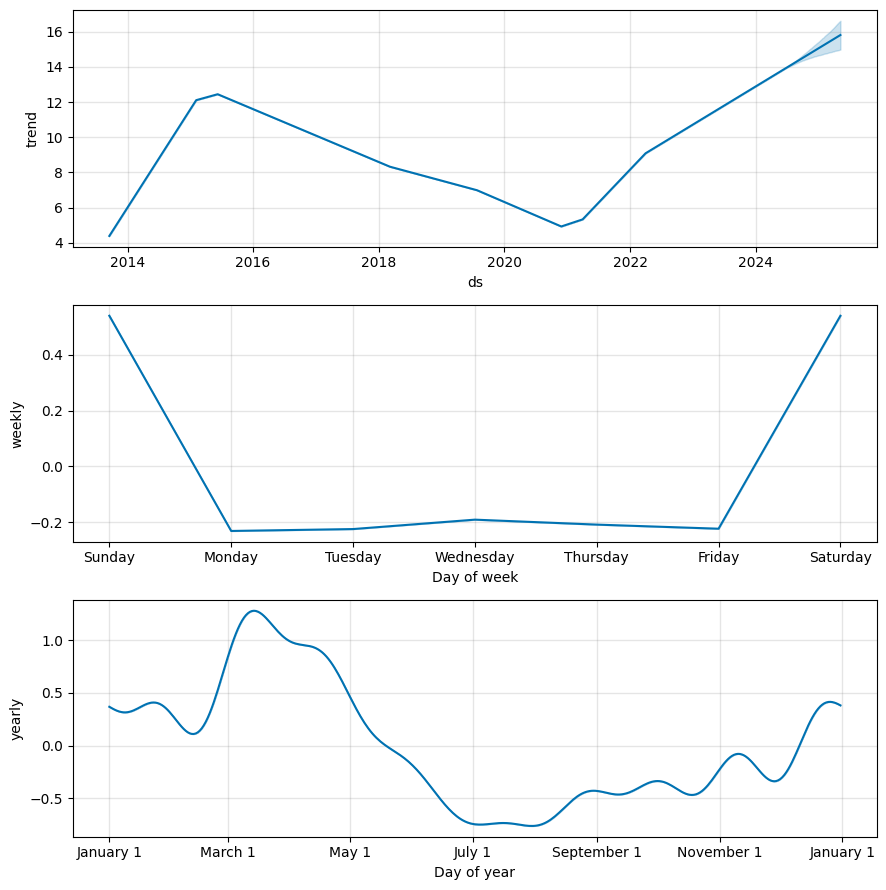

In [96]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast)
plt.show()

# NeuralProphet on df

In [97]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.211% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (42) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [98]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(df)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.211% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.211% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.211% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 42it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2648,2024-05-02,16.0,14.222197,1.415889,0.315934,12.490375
2649,2024-05-03,16.0,14.216728,1.423895,0.302970,12.489864
2650,2024-05-06,16.0,14.154286,1.447914,0.262246,12.444127
2651,2024-05-07,16.0,14.233186,1.455921,0.248076,12.529188
2652,2024-05-08,16.0,14.213707,1.463927,0.233688,12.516092


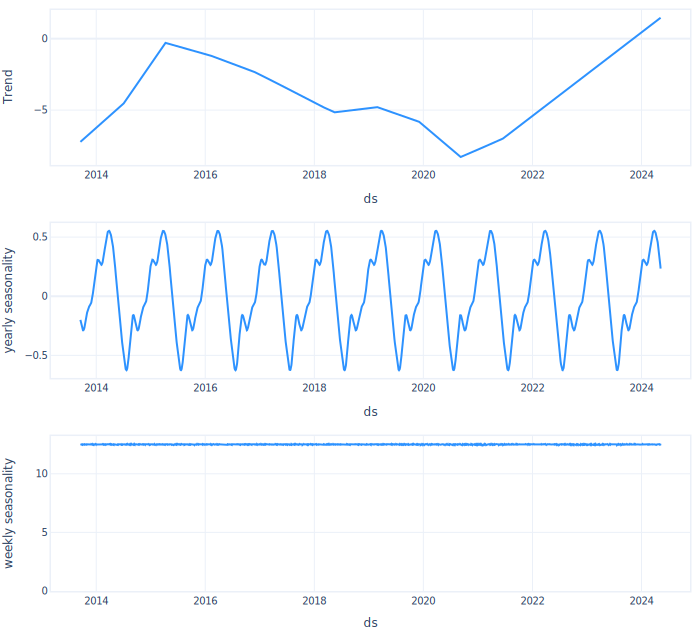

In [99]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

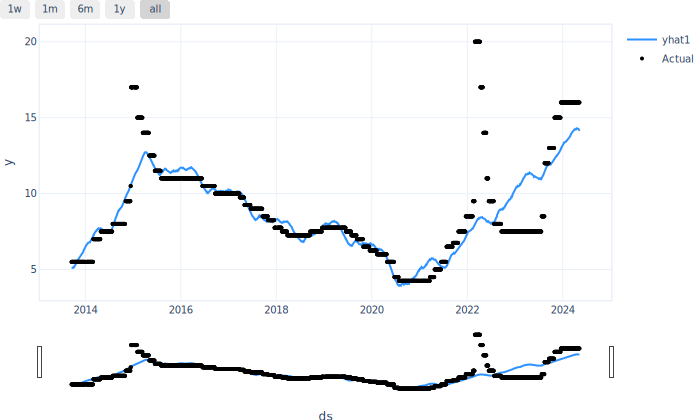

In [100]:
# Смотрим график прогноза после обучения
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей